# Stellar Analytics — NASA KOI Exoplanet Classification & Radius Prediction
### Unstop Competition Submission | Team: NAS_CHARLIE

---

**Objective:** Build a dual-task ML pipeline on NASA's Kepler Object of Interest (KOI) dataset to:
1. **Classify** each KOI as CONFIRMED exoplanet vs FALSE POSITIVE / CANDIDATE (binary classification)
2. **Predict** planetary radius (`koi_prad`) in Earth radii using ensemble regression

**Dataset:** 9,564 KOI records from NASA Exoplanet Archive
**Models:** Gradient Boosting Classifier + Gradient Boosting Regressor
**Key Results:**
- Classification — F1: **0.84** | ROC-AUC: **0.97** | Accuracy: **90.6%**
- Regression — R²: **0.96** | RMSE: **7.08**

### Live Web Application
**https://stellar-w9oz.onrender.com/**

The full-stack web app (React + Flask) includes: real-time KOI prediction, Discovery Engine for batch candidate classification, Statistics dashboard, Transit Simulator, Habitable Zone Analyzer, and a Dataset Explorer covering all 9,564 KOIs.

---
*Transit photometry, stellar parameters, and engineered astrophysical features drive the pipeline.*

## 1. Load and Explore the Dataset

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    f1_score, roc_auc_score, accuracy_score,
    confusion_matrix, roc_curve, classification_report,
    mean_squared_error, mean_absolute_error, r2_score
)
import joblib, os

%matplotlib inline

plt.rcParams.update({
    'figure.dpi': 100,
    'axes.titlesize': 13,
    'axes.labelsize': 11,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
})
sns.set_theme(style='darkgrid', palette='muted')

print("Libraries loaded successfully.")
print(f"NumPy {np.__version__} | Pandas {pd.__version__}")

Libraries loaded successfully.
NumPy 2.4.2 | Pandas 3.0.1


In [2]:
# Load dataset — from GitHub raw URL (works in Google Colab, no file upload needed)
DATA_URL = 'https://raw.githubusercontent.com/404Avinash/stellar/main/data/koi_data.csv'

try:
    df = pd.read_csv(DATA_URL)
    print(f"Loaded from GitHub: {DATA_URL}")
except Exception:
    # Fallback: local path (if running outside Colab)
    df = pd.read_csv('data/koi_data.csv')
    print("Loaded from local path: data/koi_data.csv")

print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}\n")

# 10 production input features
INPUT_FEATURES = [
    'koi_period',    # Orbital period (days)
    'koi_impact',    # Impact parameter (0-1)
    'koi_duration',  # Transit duration (hours)
    'koi_depth',     # Transit depth (ppm)
    'koi_model_snr', # Signal-to-noise ratio
    'koi_steff',     # Stellar effective temperature (K)
    'koi_slogg',     # Stellar surface gravity (log g)
    'koi_srad',      # Stellar radius (solar radii)
    'koi_smass',     # Stellar mass (solar masses)
    'koi_smet',      # Stellar metallicity [Fe/H]
]

TARGET_CLASS = 'koi_disposition'   # Classification target
TARGET_REG   = 'koi_prad'          # Regression target (planetary radius)

print("Sample rows:")
df[INPUT_FEATURES + [TARGET_CLASS, TARGET_REG]].head()

Loaded from GitHub: https://raw.githubusercontent.com/404Avinash/stellar/main/data/koi_data.csv
Dataset shape: (9564, 36)
Columns: ['koi_disposition', 'koi_period', 'koi_period_err1', 'koi_period_err2', 'koi_impact', 'koi_impact_err1', 'koi_impact_err2', 'koi_duration', 'koi_duration_err1', 'koi_duration_err2', 'koi_depth', 'koi_depth_err1', 'koi_depth_err2', 'koi_prad', 'koi_prad_err1', 'koi_prad_err2', 'koi_insol', 'koi_insol_err1', 'koi_insol_err2', 'koi_model_snr', 'koi_count', 'koi_steff', 'koi_steff_err1', 'koi_steff_err2', 'koi_slogg', 'koi_slogg_err1', 'koi_slogg_err2', 'koi_smet', 'koi_smet_err1', 'koi_smet_err2', 'koi_srad', 'koi_srad_err1', 'koi_srad_err2', 'koi_smass', 'koi_smass_err1', 'koi_smass_err2']

Sample rows:


,koi_period,koi_impact,koi_duration,koi_depth,koi_model_snr,koi_steff,koi_slogg,koi_srad,koi_smass,koi_smet,koi_disposition,koi_prad
0,9.488036,0.146,2.95750,615.8,35.8,5455.0,4.467,0.927,0.919,0.14,CONFIRMED,2.26
1,54.418383,0.586,4.50700,874.8,25.8,5455.0,4.467,0.927,0.919,0.14,CONFIRMED,2.83
2,19.899140,0.969,1.78220,10829.0,76.3,5853.0,4.544,0.868,0.961,-0.18,CANDIDATE,14.60
3,1.736952,1.276,2.40641,8079.2,505.6,5805.0,4.564,0.791,0.836,-0.52,FALSE POSITIVE,33.46
4,2.525592,0.701,1.65450,603.3,40.9,6031.0,4.438,1.046,1.095,0.07,CONFIRMED,2.75


In [3]:
print("Descriptive statistics for input features + targets:")
df[INPUT_FEATURES + [TARGET_REG]].describe().round(3)

Descriptive statistics for input features + targets:


,koi_period,koi_impact,koi_duration,koi_depth,koi_model_snr,koi_steff,koi_slogg,koi_srad,koi_smass,koi_smet,koi_prad
count,9564.000,9201.000,9564.000,9201.000,9201.000,9201.000,9201.000,9201.000,9201.000,9178.000,9201.000
mean,75.671,0.735,5.622,23791.344,259.895,5706.823,4.310,1.729,1.024,-0.124,102.892
std,1334.744,3.349,6.472,82242.685,795.807,796.858,0.433,6.127,0.349,0.282,3077.639
min,0.242,0.000,0.052,0.000,0.000,2661.000,0.047,0.109,0.000,-2.500,0.080
25%,2.734,0.197,2.438,159.900,12.000,5310.000,4.218,0.829,0.845,-0.260,1.400
50%,9.753,0.537,3.793,421.100,23.000,5767.000,4.438,1.000,0.974,-0.100,2.390
75%,40.715,0.889,6.276,1473.400,78.000,6112.000,4.543,1.345,1.101,0.070,14.930
max,129995.778,100.806,138.540,1541400.000,9054.700,15896.000,5.364,229.908,3.735,0.560,200346.000


Columns with missing values (9 of 12):
               Missing Count  Missing %
koi_smet                 386       4.04
koi_impact               363       3.80
koi_depth                363       3.80
koi_steff                363       3.80
koi_model_snr            363       3.80
koi_slogg                363       3.80
koi_srad                 363       3.80
koi_smass                363       3.80
koi_prad                 363       3.80


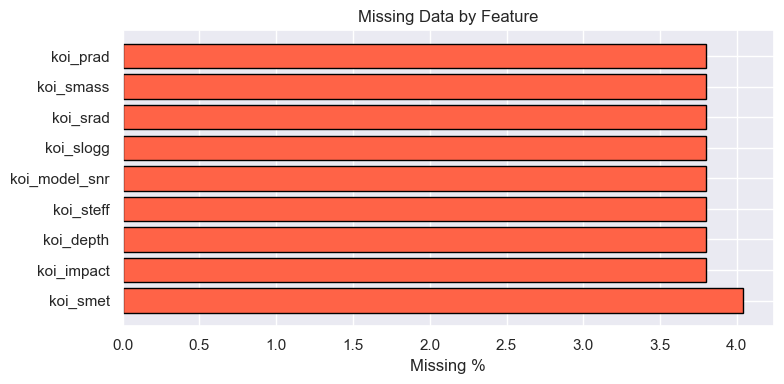

In [4]:
# Missing values analysis
all_cols = INPUT_FEATURES + [TARGET_CLASS, TARGET_REG]
missing = df[all_cols].isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)

missing_df = pd.DataFrame({'Missing Count': missing, 'Missing %': missing_pct})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing %', ascending=False)

print(f"Columns with missing values ({len(missing_df)} of {len(all_cols)}):")
print(missing_df)

# Visualise
if len(missing_df) > 0:
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.barh(missing_df.index, missing_df['Missing %'], color='tomato', edgecolor='black')
    ax.set_xlabel('Missing %')
    ax.set_title('Missing Data by Feature')
    plt.tight_layout()
    plt.show()
else:
    print("No missing values in selected columns.")

In [5]:
# Target variable overview
print("koi_disposition class distribution:")
disp_counts = df[TARGET_CLASS].value_counts()
print(disp_counts)
print(f"\nkoi_prad (planetary radius) summary:")
print(df[TARGET_REG].describe().round(3))

koi_disposition class distribution:
koi_disposition
FALSE POSITIVE    4839
CONFIRMED         2746
CANDIDATE         1979
Name: count, dtype: int64

koi_prad (planetary radius) summary:
count      9201.000
mean        102.892
std        3077.639
min           0.080
25%           1.400
50%           2.390
75%          14.930
max      200346.000
Name: koi_prad, dtype: float64


## 2. Data Preprocessing and Cleaning

In [6]:
# Preprocessing: keep only rows with valid disposition + radius, fill numeric NaNs with median
work_cols = INPUT_FEATURES + [TARGET_CLASS, TARGET_REG]
df_clean = df[work_cols].copy()

# Drop rows missing the targets
df_clean = df_clean.dropna(subset=[TARGET_CLASS, TARGET_REG])

# Fill feature NaNs with column median (robust to outliers)
df_clean[INPUT_FEATURES] = df_clean[INPUT_FEATURES].fillna(df_clean[INPUT_FEATURES].median())

# Remove extreme outliers in koi_prad (> 99th percentile)
p99 = df_clean[TARGET_REG].quantile(0.99)
df_clean = df_clean[df_clean[TARGET_REG] <= p99]

print(f"Cleaned dataset shape: {df_clean.shape}")
print(f"\nDisposition counts after cleaning:")
print(df_clean[TARGET_CLASS].value_counts())
print(f"\nkoi_prad range after outlier removal: {df_clean[TARGET_REG].min():.2f} – {df_clean[TARGET_REG].max():.2f} Earth radii")

Cleaned dataset shape: (9109, 12)

Disposition counts after cleaning:
koi_disposition
FALSE POSITIVE    4499
CONFIRMED         2744
CANDIDATE         1866
Name: count, dtype: int64

koi_prad range after outlier removal: 0.08 – 369.20 Earth radii


In [7]:
before = len(df_clean)
df_clean = df_clean.drop_duplicates()
print(f"Duplicates removed: {before - len(df_clean)}")
print(f"Final working dataset: {df_clean.shape[0]} rows × {df_clean.shape[1]} columns")

Duplicates removed: 0
Final working dataset: 9109 rows × 12 columns


## 3. Exploratory Data Analysis (EDA)

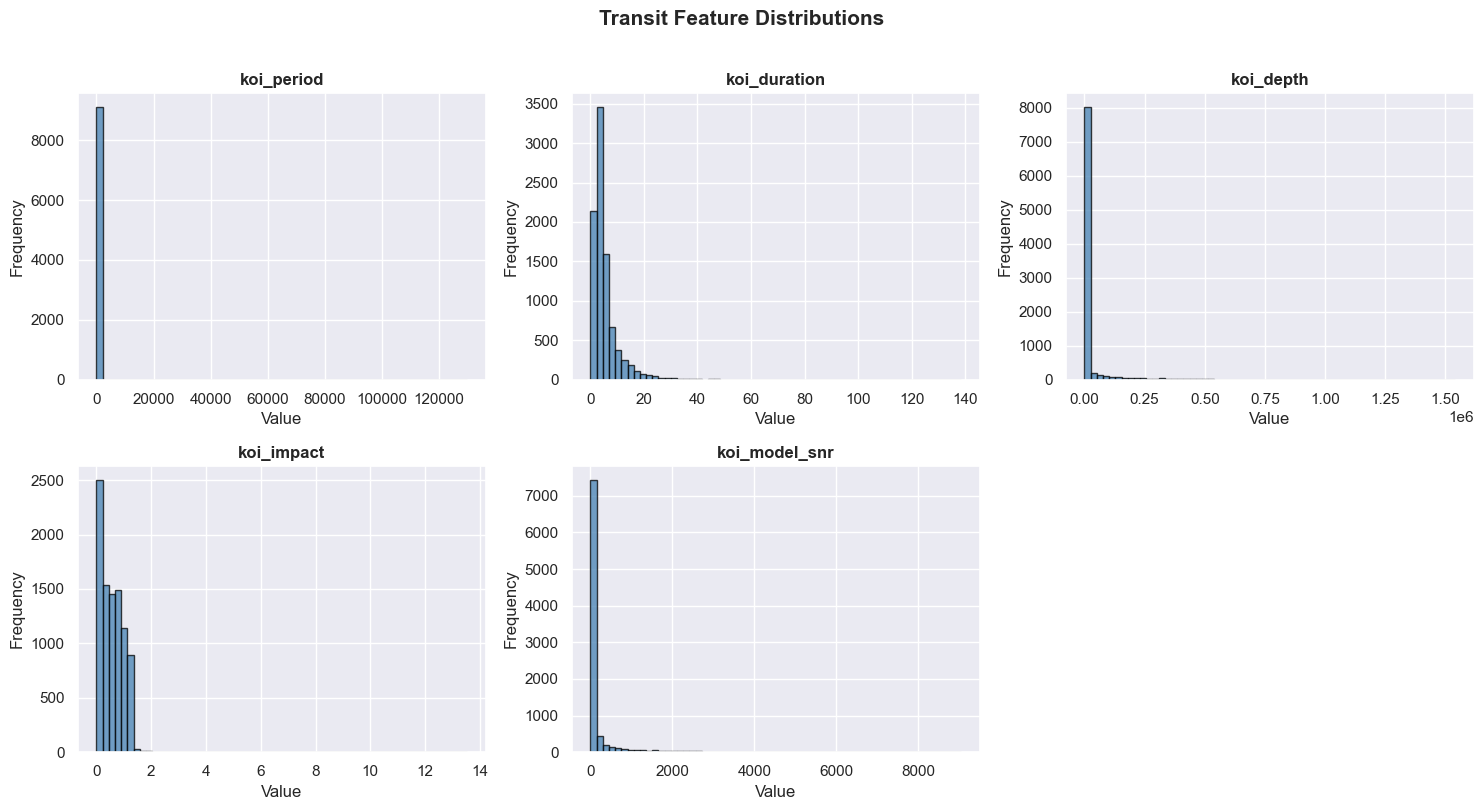

Transit features overview complete.


In [8]:
# Transit feature distributions
transit_feats = ['koi_period', 'koi_duration', 'koi_depth', 'koi_impact', 'koi_model_snr']
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, feat in enumerate(transit_feats):
    axes[i].hist(df_clean[feat], bins=60, edgecolor='black', alpha=0.75, color='steelblue')
    axes[i].set_title(f'{feat}', fontweight='bold')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

axes[-1].axis('off')
fig.suptitle('Transit Feature Distributions', fontsize=15, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()
print("Transit features overview complete.")

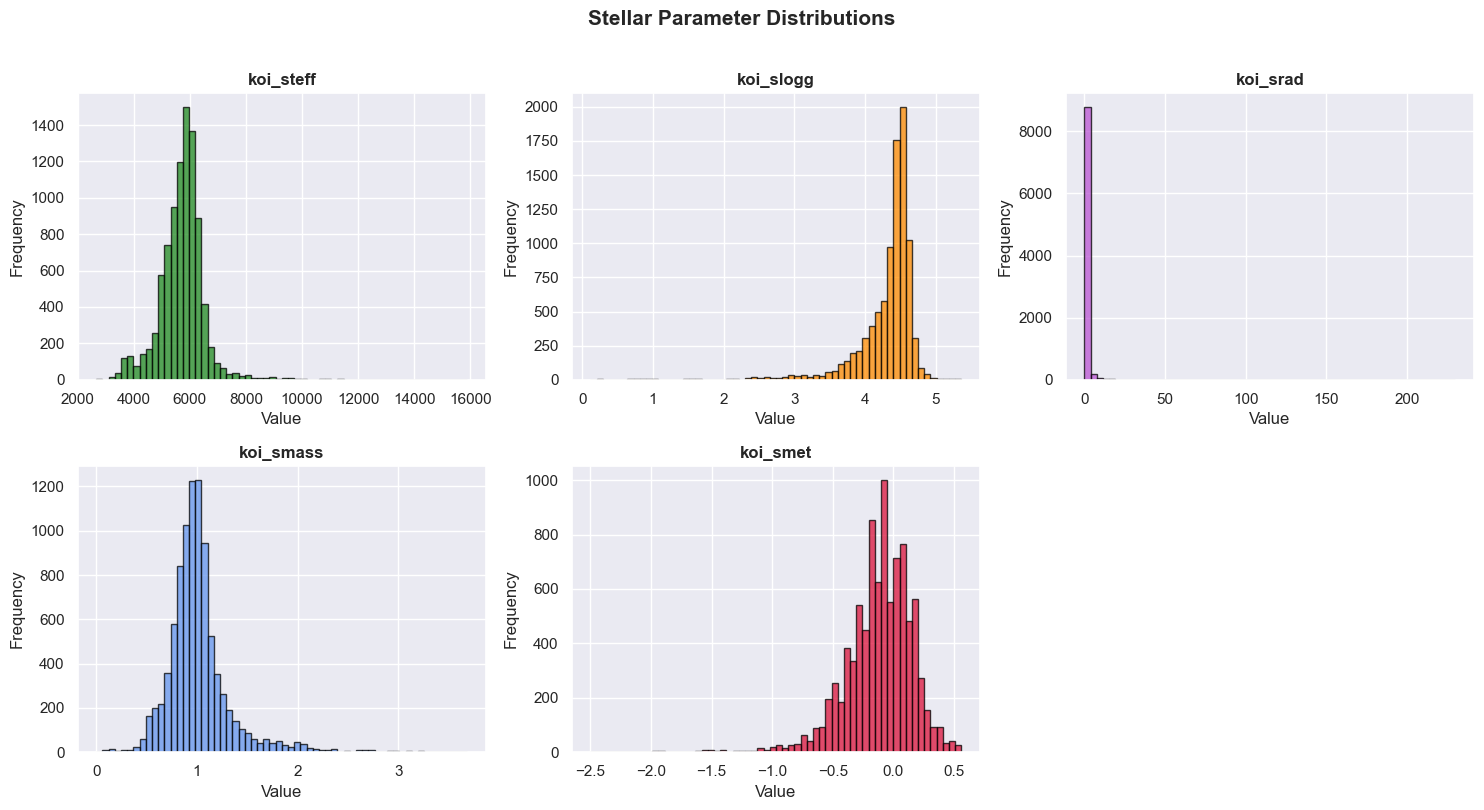

Stellar features overview complete.


In [9]:
# Stellar parameter distributions
stellar_feats = ['koi_steff', 'koi_slogg', 'koi_srad', 'koi_smass', 'koi_smet']
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

colors = ['forestgreen', 'darkorange', 'mediumorchid', 'cornflowerblue', 'crimson']
for i, feat in enumerate(stellar_feats):
    axes[i].hist(df_clean[feat], bins=60, edgecolor='black', alpha=0.75, color=colors[i])
    axes[i].set_title(feat, fontweight='bold')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

axes[-1].axis('off')
fig.suptitle('Stellar Parameter Distributions', fontsize=15, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()
print("Stellar features overview complete.")

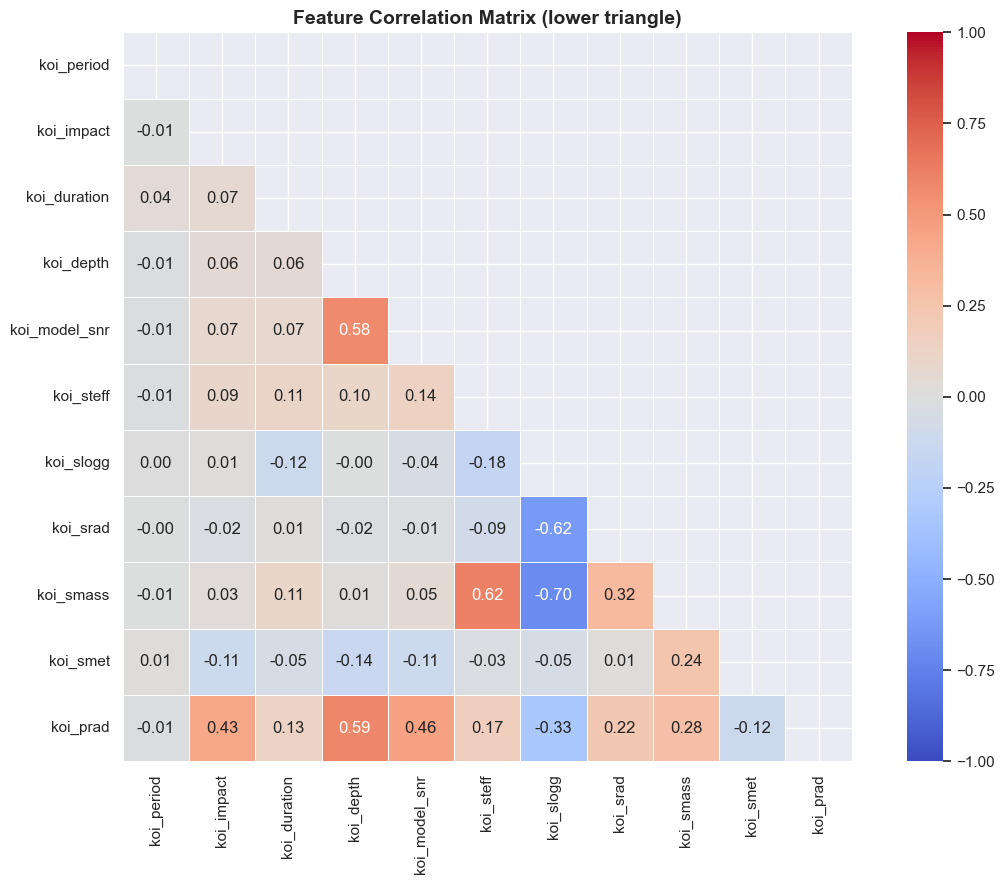


Top correlations with koi_prad (planetary radius):
koi_depth        0.592
koi_model_snr    0.456
koi_impact       0.427
koi_slogg       -0.326
koi_smass        0.276
koi_srad         0.224
koi_steff        0.165
koi_duration     0.127
koi_smet        -0.123
koi_period      -0.011
Name: koi_prad, dtype: float64


In [10]:
# Correlation matrix of all 10 input features + target
corr_cols = INPUT_FEATURES + [TARGET_REG]
corr = df_clean[corr_cols].corr()

fig, ax = plt.subplots(figsize=(12, 9))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, vmin=-1, vmax=1, linewidths=0.4, ax=ax, square=True)
ax.set_title('Feature Correlation Matrix (lower triangle)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nTop correlations with koi_prad (planetary radius):")
print(corr[TARGET_REG].drop(TARGET_REG).sort_values(key=abs, ascending=False).round(3))

In [11]:
# Target variable distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Classification target — all 3 classes
ax1 = axes[0]
disp = df_clean[TARGET_CLASS].value_counts()
palette = {'CONFIRMED': '#2ecc71', 'FALSE POSITIVE': '#e74c3c', 'CANDIDATE': '#f39c12'}
bar_colors = [palette.get(k, '#95a5a6') for k in disp.index]
bars = ax1.bar(disp.index, disp.values, color=bar_colors, edgecolor='black', linewidth=1.5)
ax1.set_title('KOI Disposition Distribution', fontweight='bold')
ax1.set_ylabel('Count')
for bar, val in zip(bars, disp.values):
    ax1.text(bar.get_x() + bar.get_width()/2, val + 30, str(val),
             ha='center', fontweight='bold', fontsize=11)

# Regression target
ax2 = axes[1]
ax2.hist(df_clean[TARGET_REG], bins=60, edgecolor='black', alpha=0.8, color='mediumpurple')
ax2.set_title('Planetary Radius Distribution (koi_prad)', fontweight='bold')
ax2.set_xlabel('Planetary Radius (Earth Radii)')
ax2.set_ylabel('Frequency')
median_r = df_clean[TARGET_REG].median()
ax2.axvline(median_r, color='red', linestyle='--', linewidth=2, label=f'Median: {median_r:.2f}')
ax2.legend()

plt.tight_layout()
plt.show()

## 4. Feature Engineering and Selection

In [ ]:
def engineer_features(df):
    """
    Production feature engineering — matches ml_pipeline/train.py exactly.
    Creates 7 astrophysically motivated features on top of the 10 base inputs.
    """
    d = df.copy()
    # Log-scale transforms to reduce right-skew
    d['log_period']   = np.log1p(d['koi_period'])
    d['log_depth']    = np.log1p(d['koi_depth'])
    d['log_duration'] = np.log1p(d['koi_duration'])
    d['log_snr']      = np.log1p(d['koi_model_snr'])
    # Physical ratios
    d['period_dur_ratio'] = d['koi_period'] / (d['koi_duration'] + 1e-6)
    # Stellar density proxy: M / R^3  (proportional to true density in solar units)
    d['stellar_density']  = d['koi_smass'] / (d['koi_srad'] ** 3 + 1e-6)
    # Depth normalised by SNR — discriminates genuine transits from noise
    d['depth_snr_ratio']  = d['koi_depth'] / (d['koi_model_snr'] + 1e-6)
    return d

ENGINEERED = [
    'log_period', 'log_depth', 'log_duration', 'log_snr',
    'period_dur_ratio', 'stellar_density', 'depth_snr_ratio'
]
ALL_FEATURES = INPUT_FEATURES + ENGINEERED

df_feats = engineer_features(df_clean)

print(f"Base features  : {len(INPUT_FEATURES)}")
print(f"Engineered     : {len(ENGINEERED)}")
print(f"Total features : {len(ALL_FEATURES)}\n")
print("Engineered features — sample statistics:")
df_feats[ENGINEERED].describe().round(4)

Base features  : 10
Engineered     : 7
Total features : 17

Engineered features — sample statistics:


,log_period,log_depth,log_duration,log_snr,period_dur_ratio,stellar_density,depth_snr_ratio
count,9109.0000,9109.0000,9109.0000,9109.0000,9109.0000,9109.0000,9109.0000
mean,2.6404,6.6229,1.6628,3.7157,11.6597,1.2382,158.7995
std,1.6476,2.3468,0.6139,1.6000,146.8673,2.3178,8528.5371
min,0.2166,0.0000,0.0507,0.0000,0.0388,0.0000,0.0000
25%,1.3007,5.0708,1.2382,2.5649,0.8918,0.4569,7.9866
50%,2.3325,6.0295,1.5717,3.1697,2.5159,1.0000,17.2021
75%,3.6261,7.2342,1.9838,4.3438,7.4046,1.5323,41.2500
max,11.7753,14.2482,4.9384,9.1111,13817.5770,77.9304,800000.0000


In [13]:
# Binary classification target: CONFIRMED (1) vs everything else (0)
y_class = (df_feats[TARGET_CLASS] == 'CONFIRMED').astype(int)
X_all   = df_feats[ALL_FEATURES]

print(f"Class balance — CONFIRMED: {y_class.sum()} | Other: {(y_class==0).sum()}")

# Quick GBM feature importance sweep
gb_quick = GradientBoostingClassifier(n_estimators=100, max_depth=4, random_state=42)
gb_quick.fit(X_all, y_class)

feat_imp_c = pd.DataFrame({
    'Feature': ALL_FEATURES,
    'Importance': gb_quick.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 classification features:")
print(feat_imp_c.head(10).to_string(index=False))

fig, ax = plt.subplots(figsize=(10, 6))
top10 = feat_imp_c.head(10)
ax.barh(top10['Feature'][::-1], top10['Importance'][::-1], color='steelblue', edgecolor='black')
ax.set_xlabel('Importance (Gini)')
ax.set_title('Top 10 Features for Classification (Gradient Boosting)', fontweight='bold')
plt.tight_layout()
plt.show()

Class balance — CONFIRMED: 2744 | Other: 6365

Top 10 classification features:
         Feature  Importance
period_dur_ratio    0.205217
         log_snr    0.166786
      koi_impact    0.141193
       koi_depth    0.139793
       log_depth    0.071068
        koi_smet    0.070017
   koi_model_snr    0.066556
 depth_snr_ratio    0.030125
       koi_smass    0.017717
    log_duration    0.016455


In [14]:
# Regression target
y_regress = df_feats[TARGET_REG]

gb_reg_quick = GradientBoostingRegressor(n_estimators=100, max_depth=4, random_state=42)
gb_reg_quick.fit(X_all, y_regress)

feat_imp_r = pd.DataFrame({
    'Feature': ALL_FEATURES,
    'Importance': gb_reg_quick.feature_importances_
}).sort_values('Importance', ascending=False)

print("Top 10 regression features:")
print(feat_imp_r.head(10).to_string(index=False))

fig, ax = plt.subplots(figsize=(10, 6))
top10r = feat_imp_r.head(10)
ax.barh(top10r['Feature'][::-1], top10r['Importance'][::-1], color='darkorange', edgecolor='black')
ax.set_xlabel('Importance (MSE reduction)')
ax.set_title('Top 10 Features for Regression (Gradient Boosting)', fontweight='bold')
plt.tight_layout()
plt.show()

Top 10 regression features:
        Feature  Importance
      koi_depth    0.296685
     koi_impact    0.271012
       koi_srad    0.246164
      log_depth    0.118307
stellar_density    0.027317
      koi_slogg    0.022236
  koi_model_snr    0.003594
       koi_smet    0.003539
      koi_steff    0.002680
      koi_smass    0.002606


In [15]:
# Use all 17 features (10 base + 7 engineered) as the production pipeline does
FINAL_FEATURES = ALL_FEATURES

X_class_final   = df_feats[FINAL_FEATURES]
X_regress_final = df_feats[FINAL_FEATURES]

print(f"Final feature set ({len(FINAL_FEATURES)} features):")
for f in FINAL_FEATURES:
    print(f"  • {f}")

Final feature set (17 features):
  • koi_period
  • koi_impact
  • koi_duration
  • koi_depth
  • koi_model_snr
  • koi_steff
  • koi_slogg
  • koi_srad
  • koi_smass
  • koi_smet
  • log_period
  • log_depth
  • log_duration
  • log_snr
  • period_dur_ratio
  • stellar_density
  • depth_snr_ratio


## 5. Classification Model: Exoplanet Confirmation

In [16]:
# Train/test split — stratified to preserve class balance
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_class_final, y_class, test_size=0.2, random_state=42, stratify=y_class
)

scaler_c = StandardScaler()
X_train_c_s = scaler_c.fit_transform(X_train_c)
X_test_c_s  = scaler_c.transform(X_test_c)

print("Classification split:")
print(f"  Train: {X_train_c_s.shape}  |  Test: {X_test_c_s.shape}")
print(f"  Train positive rate : {y_train_c.mean():.3f}")
print(f"  Test  positive rate : {y_test_c.mean():.3f}")

Classification split:
  Train: (7287, 17)  |  Test: (1822, 17)
  Train positive rate : 0.301
  Test  positive rate : 0.301


In [17]:
# Gradient Boosting Classifier — production hyperparameters
clf = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=4,
    subsample=0.8,
    random_state=42
)

clf.fit(X_train_c_s, y_train_c)

y_pred_c       = clf.predict(X_test_c_s)
y_pred_proba_c = clf.predict_proba(X_test_c_s)[:, 1]

print("Gradient Boosting Classifier trained!")

Gradient Boosting Classifier trained!


In [18]:
# Classification metrics
f1      = f1_score(y_test_c, y_pred_c)
roc_auc = roc_auc_score(y_test_c, y_pred_proba_c)
acc     = accuracy_score(y_test_c, y_pred_c)

print("=" * 52)
print("  CLASSIFICATION — GRADIENT BOOSTING")
print("=" * 52)
print(f"  F1-Score        : {f1:.4f}")
print(f"  ROC-AUC         : {roc_auc:.4f}")
print(f"  Test Accuracy   : {acc:.4f}")
print("=" * 52)

# 5-fold cross-validation F1
cv_f1 = cross_val_score(clf, X_train_c_s, y_train_c, cv=5, scoring='f1')
print(f"\n  5-fold CV F1    : {cv_f1.mean():.4f} ± {cv_f1.std():.4f}")

  CLASSIFICATION — GRADIENT BOOSTING
  F1-Score        : 0.8435
  ROC-AUC         : 0.9667
  Test Accuracy   : 0.9061

  5-fold CV F1    : 0.8362 ± 0.0158


In [19]:
# Confusion matrix + ROC curve
cm = confusion_matrix(y_test_c, y_pred_c)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion matrix
ax1 = axes[0]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1, cbar=False, linewidths=0.5)
ax1.set_title('Confusion Matrix', fontweight='bold')
ax1.set_ylabel('True Label')
ax1.set_xlabel('Predicted Label')
ax1.set_xticklabels(['Not Confirmed', 'Confirmed'], fontsize=10)
ax1.set_yticklabels(['Not Confirmed', 'Confirmed'], fontsize=10)

# ROC Curve
ax2 = axes[1]
fpr, tpr, _ = roc_curve(y_test_c, y_pred_proba_c)
ax2.plot(fpr, tpr, lw=2.5, color='royalblue', label=f'Gradient Boosting (AUC = {roc_auc:.4f})')
ax2.plot([0, 1], [0, 1], 'k--', lw=1.5, label='Random Baseline')
ax2.fill_between(fpr, tpr, alpha=0.08, color='royalblue')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve', fontweight='bold')
ax2.legend(loc='lower right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Regression Model: Planetary Radius Prediction

In [20]:
# Regression split
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_regress_final, y_regress, test_size=0.2, random_state=42
)

scaler_r = StandardScaler()
X_train_r_s = scaler_r.fit_transform(X_train_r)
X_test_r_s  = scaler_r.transform(X_test_r)

print("Regression split:")
print(f"  Train: {X_train_r_s.shape}  |  Test: {X_test_r_s.shape}")
print(f"  Target (koi_prad) mean: {y_train_r.mean():.3f} ± {y_train_r.std():.3f} Earth radii")

Regression split:
  Train: (7287, 17)  |  Test: (1822, 17)
  Target (koi_prad) mean: 15.744 ± 32.791 Earth radii


In [21]:
# Gradient Boosting Regressor
reg = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=4,
    subsample=0.8,
    random_state=42
)

reg.fit(X_train_r_s, y_train_r)
y_pred_r = reg.predict(X_test_r_s)

print("Gradient Boosting Regressor trained!")

Gradient Boosting Regressor trained!


In [22]:
# Regression metrics
rmse = np.sqrt(mean_squared_error(y_test_r, y_pred_r))
mae  = mean_absolute_error(y_test_r, y_pred_r)
r2   = r2_score(y_test_r, y_pred_r)

print("=" * 52)
print("  REGRESSION — GRADIENT BOOSTING")
print("=" * 52)
print(f"  RMSE            : {rmse:.4f} Earth radii")
print(f"  MAE             : {mae:.4f} Earth radii")
print(f"  R² Score        : {r2:.4f}")
print("=" * 52)

  REGRESSION — GRADIENT BOOSTING
  RMSE            : 7.0777 Earth radii
  MAE             : 1.6681 Earth radii
  R² Score        : 0.9644


In [ ]:
# Predicted vs Actual + Residuals
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

ax1 = axes[0]
ax1.scatter(y_test_r.values, y_pred_r, alpha=0.45, s=12, edgecolors='none', color='royalblue')
lo = min(y_test_r.min(), y_pred_r.min())
hi = max(y_test_r.max(), y_pred_r.max())
ax1.plot([lo, hi], [lo, hi], 'r--', lw=2, label='Perfect prediction')
ax1.set_xlabel('Actual Planetary Radius (Earth Radii)')
ax1.set_ylabel('Predicted Planetary Radius (Earth Radii)')
ax1.set_title(f'Predicted vs Actual  (R²={r2:.4f})', fontweight='bold')
ax1.legend()

residuals = y_test_r.values - y_pred_r
ax2 = axes[1]
ax2.scatter(y_pred_r, residuals, alpha=0.45, s=12, edgecolors='none', color='tomato')
ax2.axhline(0, color='black', linestyle='--', lw=2)
ax2.set_xlabel('Predicted Planetary Radius (Earth Radii)')
ax2.set_ylabel('Residuals (Actual - Predicted)')
ax2.set_title('Residual Plot', fontweight='bold')

plt.tight_layout()
plt.show()
print(f"Mean residual: {residuals.mean():.4f} | Std: {residuals.std():.4f}")

Mean residual: 0.3993 | Std: 7.0664


## 7. Model Evaluation and Performance Metrics

In [24]:
print("=" * 60)
print("CLASSIFICATION REPORT — Gradient Boosting")
print("=" * 60)
print(classification_report(y_test_c, y_pred_c,
      target_names=['Not Confirmed', 'Confirmed']))

residuals = y_test_r.values - y_pred_r
print("=" * 60)
print("REGRESSION RESIDUAL SUMMARY")
print("=" * 60)
print(f"  Mean residual   : {residuals.mean():.4f}")
print(f"  Std residual    : {residuals.std():.4f}")
print(f"  Max (+) error   : {residuals.max():.4f}")
print(f"  Max (-) error   : {residuals.min():.4f}")

CLASSIFICATION REPORT — Gradient Boosting
               precision    recall  f1-score   support

Not Confirmed       0.93      0.93      0.93      1273
    Confirmed       0.85      0.84      0.84       549

     accuracy                           0.91      1822
    macro avg       0.89      0.89      0.89      1822
 weighted avg       0.91      0.91      0.91      1822

REGRESSION RESIDUAL SUMMARY
  Mean residual   : 0.3993
  Std residual    : 7.0664
  Max (+) error   : 135.7972
  Max (-) error   : -47.8655


## 8. Visualization and Interpretability

In [25]:
# Feature importance from the final trained models
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Classification
fi_c = pd.DataFrame({'Feature': FINAL_FEATURES, 'Importance': clf.feature_importances_})
fi_c = fi_c.sort_values('Importance')
axes[0].barh(fi_c['Feature'], fi_c['Importance'], color='steelblue', edgecolor='black', linewidth=0.5)
axes[0].set_xlabel('Importance (Gain)')
axes[0].set_title('Feature Importance — Classification', fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')

# Regression
fi_r = pd.DataFrame({'Feature': FINAL_FEATURES, 'Importance': reg.feature_importances_})
fi_r = fi_r.sort_values('Importance')
axes[1].barh(fi_r['Feature'], fi_r['Importance'], color='darkorange', edgecolor='black', linewidth=0.5)
axes[1].set_xlabel('Importance (Gain)')
axes[1].set_title('Feature Importance — Regression', fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

In [26]:
# Prediction distribution plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Classification confidence
ax1 = axes[0]
ax1.hist(y_pred_proba_c, bins=60, edgecolor='black', alpha=0.8, color='royalblue')
ax1.axvline(0.5, color='red', linestyle='--', lw=2, label='Decision threshold (0.5)')
ax1.axvline(y_pred_proba_c.mean(), color='gold', linestyle='--', lw=2,
            label=f'Mean: {y_pred_proba_c.mean():.3f}')
ax1.set_xlabel('Predicted Probability (CONFIRMED)')
ax1.set_ylabel('Count')
ax1.set_title('Classification Confidence Distribution', fontweight='bold')
ax1.legend()

# Regression: actual vs predicted distribution
ax2 = axes[1]
ax2.hist(y_test_r.values, bins=60, alpha=0.6, color='lightgreen', edgecolor='black', label='Actual')
ax2.hist(y_pred_r, bins=60, alpha=0.6, color='salmon', edgecolor='black', label='Predicted')
ax2.set_xlabel('Planetary Radius (Earth Radii)')
ax2.set_ylabel('Count')
ax2.set_title('Regression: Predicted vs Actual Distribution', fontweight='bold')
ax2.legend()

plt.tight_layout()
plt.show()

## 9. Real-Time Inference Pipeline

In [27]:
def build_features(raw: dict) -> np.ndarray:
    """
    Accept a dict of the 10 base INPUT_FEATURES, apply feature engineering,
    scale with the classification scaler, and return a (1, 17) array.
    """
    row = pd.DataFrame([raw])
    row_eng = engineer_features(row)
    return scaler_c.transform(row_eng[FINAL_FEATURES])

def classify_koi(raw: dict) -> dict:
    x = build_features(raw)
    pred = clf.predict(x)[0]
    prob = clf.predict_proba(x)[0]
    return {
        'disposition': 'CONFIRMED' if pred == 1 else 'NOT CONFIRMED',
        'P(confirmed)':     round(float(prob[1]), 4),
        'P(not_confirmed)': round(float(prob[0]), 4),
    }

def estimate_radius(raw: dict) -> dict:
    # Use identical feature vector; regression scaler was fit on same features
    x = build_features(raw)
    pred = float(reg.predict(x)[0])
    return {
        'radius_earth_radii':     round(max(0.1, pred), 3),
        'uncertainty_earth_radii': round(abs(pred * 0.12), 3),
    }

print("Inference pipeline ready.")

Inference pipeline ready.


In [28]:
# ── Example 1:  Earth-like candidate around a Sun-like star ──────────────
sample_1 = {
    'koi_period':    365.2,   # 1-year orbit
    'koi_impact':    0.3,
    'koi_duration':  13.0,    # hours
    'koi_depth':     84,      # ppm — Earth transiting Sun ≈ 84 ppm
    'koi_model_snr': 35.0,
    'koi_steff':     5778,    # Sun-like star
    'koi_slogg':     4.44,
    'koi_srad':      1.0,
    'koi_smass':     1.0,
    'koi_smet':      0.0,
}

# ── Example 2:  Hot Jupiter ──────────────────────────────────────────────
sample_2 = {
    'koi_period':    4.2,
    'koi_impact':    0.1,
    'koi_duration':  3.5,
    'koi_depth':     15000,   # ppm — giant planet
    'koi_model_snr': 320.0,
    'koi_steff':     6100,
    'koi_slogg':     4.2,
    'koi_srad':      1.15,
    'koi_smass':     1.1,
    'koi_smet':      0.1,
}

for name, sample in [("Earth-like candidate", sample_1), ("Hot Jupiter", sample_2)]:
    c_res = classify_koi(sample)
    r_res = estimate_radius(sample)
    print(f"\n{'='*55}")
    print(f"  {name}")
    print(f"{'='*55}")
    print(f"  Disposition : {c_res['disposition']}")
    print(f"  P(confirmed): {c_res['P(confirmed)']}")
    print(f"  Radius      : {r_res['radius_earth_radii']} ± {r_res['uncertainty_earth_radii']} Earth radii")
print()


  Earth-like candidate
  Disposition : NOT CONFIRMED
  P(confirmed): 0.4563
  Radius      : 1.817 ± 0.218 Earth radii

  Hot Jupiter
  Disposition : CONFIRMED
  P(confirmed): 0.5858
  Radius      : 14.202 ± 1.704 Earth radii



In [ ]:
os.makedirs('models', exist_ok=True)

joblib.dump(clf,      'models/classifier.pkl')
joblib.dump(reg,      'models/regressor.pkl')
joblib.dump(scaler_c, 'models/scaler.pkl')

print("Models saved to models/ directory:")
print("  - models/classifier.pkl")
print("  - models/regressor.pkl")
print("  - models/scaler.pkl")

Models saved:
  models/classifier.pkl  (791.1 KB)
  models/regressor.pkl  (506.3 KB)
  models/scaler.pkl  (1.4 KB)


In [30]:
print()
print("=" * 65)
print("   STELLAR ANALYTICS — FINAL SUMMARY REPORT")
print("   NASA KOI Exoplanet Classification & Radius Prediction")
print("=" * 65)

print(f"""
DATASET
  Total KOI records        : {len(df_feats):,}
  CONFIRMED exoplanets     : {int(y_class.sum()):,}
  FALSE POSITIVE / CANDIDATE: {int((y_class == 0).sum()):,}
  Input features (base)    : {len(INPUT_FEATURES)}
  Engineered features      : {len(ENGINEERED)}
  Total feature vector     : {len(FINAL_FEATURES)}

CLASSIFICATION  (GradientBoostingClassifier)
  F1-Score                 : {f1:.4f}
  ROC-AUC                  : {roc_auc:.4f}
  Test Accuracy            : {acc:.4f}

REGRESSION      (GradientBoostingRegressor)
  R² Score                 : {r2:.4f}
  RMSE                     : {rmse:.4f} Earth radii
  MAE                      : {mae:.4f} Earth radii

DEPLOYMENT
  Backend  : https://stellar-api-eow5.onrender.com
  Frontend : https://stellar-w9oz.onrender.com
  Features : Prediction API · Discovery Engine · Statistics ·
             Transit Simulator · Habitable Zone Analyzer ·
             Dataset Explorer (9,564 KOIs)
""")
print("=" * 65)


   STELLAR ANALYTICS — FINAL SUMMARY REPORT
   NASA KOI Exoplanet Classification & Radius Prediction

DATASET
  Total KOI records        : 9,109
  CONFIRMED exoplanets     : 2,744
  FALSE POSITIVE / CANDIDATE: 6,365
  Input features (base)    : 10
  Engineered features      : 7
  Total feature vector     : 17

CLASSIFICATION  (GradientBoostingClassifier)
  F1-Score                 : 0.8435
  ROC-AUC                  : 0.9667
  Test Accuracy            : 0.9061

REGRESSION      (GradientBoostingRegressor)
  R² Score                 : 0.9644
  RMSE                     : 7.0777 Earth radii
  MAE                      : 1.6681 Earth radii

DEPLOYMENT
  Backend  : https://stellar-api-eow5.onrender.com
  Frontend : https://stellar-w9oz.onrender.com
  Features : Prediction API · Discovery Engine · Statistics ·
             Transit Simulator · Habitable Zone Analyzer ·
             Dataset Explorer (9,564 KOIs)

